# CCD Basics II Spectroscopy: Reducing spectral data
________________________________________________________________________________________-

This exercise is adapted from an introductory tutorial to IRAF (Image Reduction and Analysis Facility): http://iraf.noao.edu/ 

The IRAF tools are now no longer supported by the National Optical Astronomy Observatory, but most have been imported into equivalent python routines within the Astropy package. Right now, however, we're just using basic image math to apply the necessary corrections to data frames.

This exercise is designed to show you how to accomplish preliminary reductions of spectroscopic CCD data, including: 
 - trimming overscan regions
 - creation of a master bias
 - subtraction of the bias level
 - creation and normalization of a response function using a master (dome) flat
 - creation and normalization of an illumination correction using a master (sky) flat
 - use both the response & illumination to flat field the spectral data on the CCD chip.

The spectra for this exercise were taken at the Coude Feed telescope at Kitt Peak National Observatory by Dr. Phil Massey. The files are called sp\*.fits, and are found in on vega2 in /data/ASTR303/HW3).

## Examining the data

Load one of the object frames into ds9 to inspect it. You should see a bright vertical stripe not quite centered on a dark bacgkround. (If it's centered, go into the Scale menu and uncheck "Use DATASEC".)

The vertical stripe is the spectrum. Here, the dispersion direction is vertical, i.e. along the columns, and the spatial direction is horizontal. So, when we trace and extract the spectrum and ultimately do our wavelength calibration, we'll do all of that along columns of the CCD. 

*For any 16" spectral data you take, this will be rotated 90 degrees, with the dispersion along the rows and the spatial direction along the columns.*

Now load one of your sky flats.

(grep flat * -a --context=1)

**QUESTION:** How does this differ from the object spectrum? Why? (Think about how the slit is illuminated for a sky flat versus for a spectrum of a star.)

The sky flat spectral line is much thicker than the object spectrum.  This is because the entire slit is illuminated when taking the sky flat, while just a narrow region is illuminated when looking at just a star.

Now load one of your dome flats.

**QUESTION:** How does this differ from the sky flat spectrum? Why? 

The dome flat is an 2D image of the sky, while the sky flat is a list of 1D spectra

Now on your computer in the directory you're working, **make 4 lists of the sp\*.fits files- one list for the bias frames, one for the flat fields taken on the twilight sky (sky flats), one for the regular (dome) flats, and one for the data frames.** There are also files called "comp" files, for comparison spectra. We'll use those in the next exercise to do the dispersion solution, describing the wavelength per pixel on the CCD.

Are the data frames all the ones that aren't part of the four lists or comp files?

(fitsheader spec/* -k OBJECT|grep bias -B 1|grep -v zero)

(cp spec/sp00{01..10}.fits bias/)

(fitsheader spec/* -k OBJECT |grep sky -B 1)

(fitsheader images/*|grep dome -i)
(fitsheader -k IMAGETYP images/*|grep -i dome -B 1)

You can figure out which file is which type using the "fitsheader" command (see ccd1.ipynb) or by loading them into ds9.


## Trim overscan

Remember from the previous ccd1 exercise that the overscan region (if one exists on your chip- it does not for the 16" telescope data) is best found using a flat field frame with a large number of counts. Use the dome flat field you should have in ds9 from the previous question to find the columns corresponding to the overscan, i.e. the columns at the right of the image where the count level drops from the level in the *unexposed* region of the chip.

**QUESTION: ** Enter your overscan columns in the usual [colmin:colmax,rowmin:rowmax] format.

[319:352,ALL]

**QUESTION: ** Does this agree with the BIASSEC keyword in the header? 

(see below) [321:352,1:512]
close enough 🤔

**QUESTION: ** What is the DATASEC keyword?  You will use this below to trim your data array once we read in the FITS data.

Unsure about "keyword", but region is [1:320,1:512]

*Overscan regions for each CCD frame are used  in contexts in which the bias level changes rapidly. Rather than combining many zero frames together, one could use the bias level measured in columns of the overscan region to apply a correction across all the columns on the CCD chip. Here, we're just going to combine several bias/zero frames together to make a master bias and use that correct for the bias level in all the other frames (flats and data frames), as you'll do for your observing project.*


In [44]:
from astropy.io import fits
fil=fits.open('images/m92006.fits')
print(fil[0].header['BIASSEC'])
print(fil[0].header['DATASEC'])

[321:352,1:512]
[1:320,1:512]


In [119]:
import os
allSpec=os.listdir('spec')
biases=os.listdir('bias')
domeFlats=os.listdir('domeFlat')
skyFlats=os.listdir('skyFlat')

## Loading FITS files and extracting data

astropy.io.fits  http://docs.astropy.org/en/stable/io/fits/index.html

Now, we will do one example of reading in FITS data and subtracting this overscan region, and then we will apply that method to all the FITS files.

In [45]:
# initial imports
import numpy as np
import matplotlib.pyplot as plt

# change some default plotting parameters
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.cmap'] = 'Greys_r'

# run the %matplotlib magic command to enable inline plotting
# in the current Notebook
%matplotlib inline

#import astropy fits file handling package
from astropy.io import fits

In [47]:
#read data array from fits file
sci_fn = 'spec/sp0020.fits'  
sci_hdulist = fits.open(sci_fn)
data = sci_hdulist[0].data.astype(np.float) # define the data array and list size and data type

In [90]:
#Replace N with the correct value, corresponding to no. columns in the DATASEC above
data_trimmed = data[1:320,1:512] 

**QUESTION:** Of the data types in the lists you made, which one applies to the sp0020.fits image?

data


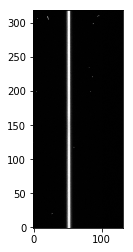

In [91]:
#Let's take a look at the data_trimmed array
plt.imshow(data_trimmed)

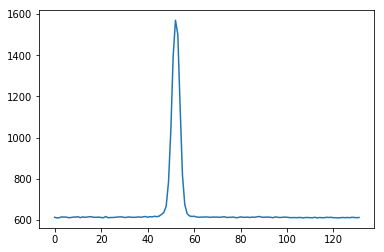

In [96]:
plt.figure()  # Start a new plot -- by default matplotlib overplots.
plt.plot(data_trimmed[300,:])

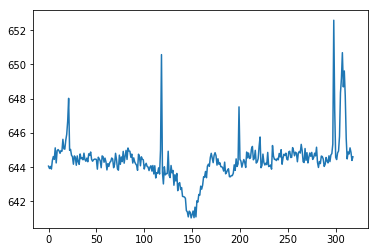

In [93]:
profile = data_trimmed.mean(axis=1)
plt.figure()
plt.plot(profile)

In [121]:
#sp_all.list is my ASCII file containing all the FITS data files- bias, flats, and object frames
#dt=np.dtype([('filename', np.unicode, 20)])
#files=np.genfromtxt("sp_all.list",dtype=dt)
#infiles=files['filename']

#infiles=["spec/"+i for i in os.listdir('spec')]

#loop over all FITS files, read them in, then read out all but the overscan region
#write the output to a file prepended with "trim\_"
for file in allSpec:
    sci_fn = 'spec/'+file
    out= "trimSpec/trim_"+file
    sci_hdulist = fits.open(sci_fn)
    data = sci_hdulist[0].data.astype(np.float)
    trimmed=data[1:320,1:512]
    hdu = fits.PrimaryHDU(trimmed)
    hdu.writeto(out,overwrite=True)

Verify that you now have a set of files called trim\_sp001.fits, trim\_sp002.fits, etc.


## Bias correction
Next, we need to create a MasterBias frame from all the trimmed bias frames. 


In [133]:
nccd=np.shape(trimmed)
nrow=nccd[0]  #here, 1024
ncol=nccd[1]  #here, 100

#read in all the trimmed zero frames to make the master bias
#sp_bias.list is my list of all the bias frames
#dt=np.dtype([('filename', np.unicode, 20)])
#files=np.genfromtxt("sp_bias.list",dtype=dt)
#infiles=files['filename']


#Code uses output of previous loop- i.e. frames with overscan trimmed are prepended with "trim_".
alldata=np.ones((len(biases),nrow,ncol))
for i in range (0,len(biases)):
    sci_fn = "trimSpec/trim_"+biases[i]
    sci_hdulist = fits.open(sci_fn)
    alldata[i,:,:] = sci_hdulist[0].data.astype(np.float)

#masterbias=np.ones((nrow,ncol))
masterbias= np.median(alldata,axis=0)

In [134]:
masterbias

array([[614. , 613. , 614. , ..., 614. , 615. , 613.5],
       [613.5, 614. , 614. , ..., 613. , 613.5, 613. ],
       [614.5, 614. , 614. , ..., 613.5, 613. , 613.5],
       ...,
       [614.5, 614. , 614. , ..., 614. , 613.5, 615. ],
       [614. , 614.5, 615. , ..., 614. , 613.5, 614. ],
       [614. , 614. , 614. , ..., 613.5, 613. , 614. ]])

Note that we have not written the masterbias array to a fits file. There's no need to do that at the moment, as we'll just use the array within this notebook later.

**QUESTION** What statistical function are we using to combine the frames? Why is this function advantageous? Recall that this is done pixel-by-pixel.

Median.  This function is advantageous because using the mean would introduce more variations from noise at the extremes, etc. The median simply extracts the middle of the dataset

Now, we need to subtract this MasterBias from all our remaining frames, i.e. the sky flats, dome flats, and object frames. 

In [127]:
#correct all the sky flat, flat, object frames using the master bias

#sky flats first- sp_skyflat.list is my list of sky flats
#dt=np.dtype([('filename', np.unicode, 20)])
#files=np.genfromtxt("sp_skyflat.list",dtype=dt)
#infiles=files['filename']


for file in skyFlats:
    sci_fn = "trimSpec/trim_"+file
    out= "biasCor/biascor_"+file
    sci_hdulist = fits.open(sci_fn)
    trimmed = sci_hdulist[0].data.astype(np.float)
    biascor= trimmed-masterbias
    hdu = fits.PrimaryHDU(biascor)
    hdu.writeto(out, overwrite=True)

#dome flats- sp_flat.list is my list of dome flats
#files=np.genfromtxt("sp_flat.list",dtype=None,names=('filename'))
#infiles=files['filename']


#The dome flats start with 'm' and the spectra start with 's'.  So
#there are no trim_dome files

for file in domeFlats:
    sci_fn = "trimSpec/trim_"+file
    out= "biasCor/biascor_"+file
    sci_hdulist = fits.open(sci_fn)
    trimmed = sci_hdulist[0].data.astype(np.float)
    biascor= trimmed-masterbias
    hdu = fits.PrimaryHDU(biascor)
    hdu.writeto(out, overwrite=True)

#object frames--- you write this loop, by adapting the loops for the other frame types above


FileNotFoundError: [Errno 2] No such file or directory: 'trimSpec/trim_m92006.fits'

## Flat Field

As you did for the MasterBias, combine the sky flats into a MasterSky frame and your dome flats into a MasterFlat frame using the median function. 


In [135]:
#read in the sky flats, make master Sky
# dt=np.dtype([('filename', np.unicode, 20)])
# files=np.genfromtxt("sp_skyflat.list",dtype=dt)
# infiles=files['filename']


alldata=np.ones((len(skyFlats),nrow,ncol))
for i in range (0,len(skyFlats)):
    sci_fn = "biasCor/biascor_"+skyFlats[i]
    sci_hdulist = fits.open(sci_fn)
    alldata[i,:,:] = sci_hdulist[0].data.astype(np.float)
mastersky=np.ones((nrow,ncol))
mastersky= np.median(alldata,axis=0)
hdu = fits.PrimaryHDU(mastersky)
hdu.writeto("MasterSky.fits", overwrite=True)

#read in the dome flats, make master Flat
# dt=np.dtype([('filename', np.unicode, 20)])
# files=np.genfromtxt("sp_flat.list",dtype=dt)
# infiles=files['filename']

alldata=np.ones((len(domeFlats),nrow,ncol))
for i in range (0,len(domeFlats)):
    sci_fn = "biasCor/biascor_"+domeFlats[i]
    sci_hdulist = fits.open(sci_fn)
    alldata[i,:,:] = sci_hdulist[0].data.astype(np.float)
masterflat=np.ones((nrow,ncol))
masterflat= np.median(alldata,axis=0)
hdu = fits.PrimaryHDU(masterflat)
hdu.writeto("MasterFlat.fits",overwrite=True)

FileNotFoundError: [Errno 2] No such file or directory: 'biasCor/biascor_m92006.fits'

Now that you've created our MasterSky and MasterFlat frames we can flat field the spectral data. This consists of two two corrections- one for Reponse (wavelength direction, here: along columns) and one for Illumination (spatial direction, here: along rows)

### Response

This portion of the flat field takes out variations in the dispersion direction (for these frames, along the columns). For this we have to be careful not to remove any true variation with wavelength so we will look at the shape of our Master Flat file along the dispersion direction (i.e. as a function of row number) then fit a function to this. 
We'll divide each row on in our MasterFlat by that function to create our Response image.

In [ ]:
#import astropy fits file handling package and read data array from fits file
from astropy.io import fits
sci_fn = 'MasterFlat.fits'  #this is my median combination of the dome flats
sci_hdulist = fits.open(sci_fn)
masterflat = sci_hdulist[0].data.astype(np.float) # define the data array and list size and data type

In [ ]:
np.shape(masterflat)

Recall the shape of our trimmed array, 1024 rows by 100 columns. 
Let's look at the slit profile, by taking a slice along row 512 of the chip: 

In [ ]:
plt.figure()  
plt.plot(masterflat[512,:])   

From this we see that column 50 or so falls right in the middle of the spatial profile, so to see if there is any difference in the CCD response along the wavelength direction, we'll plot a slice down column 50:

In [ ]:
plt.figure()  # Start a new plot -- by default matplotlib overplots.
plt.plot(masterflat[:,50])

There is quite a dramatic variation of the counts in the wavelength direction, so let's fit a function to that.

In [ ]:
x=np.arange(0, 1024)
y=masterflat[:,50]
pfit = np.polyfit(x, y, 2)  # Fit a 2nd order polynomial to (x, y) data
yfit = np.polyval(pfit, x)  # Evaluate the polynomial at x
plt.plot(x,y)
plt.plot(x,yfit)
plt.grid()

Now we'll take that function and divide the columns in our Master Flat by that to create the Response array:

In [ ]:
yfit=1./yfit
yfit=yfit[:,np.newaxis]
response=np.multiply(yfit,masterflat)

In [ ]:
plt.figure()  # Start a new plot -- by default matplotlib overplots.
plt.plot(response[:,50])

In [ ]:
plt.figure()  # Start a new plot -- by default matplotlib overplots.
plt.plot(response[512,:])

**Question** Compare the y-axis values on this plot to the ones in the slit profile above. Is this reponse normalized? Why or why not?

In [ ]:
#write the response function to a fits file in case you need it later
hdu = fits.PrimaryHDU(response)
hdu.writeto("Response.fits")

### Illumination

For this, we essentially do the same thing as in the case of the Reponse but we are generating a fit along the spatial profile that we apply across all rows. For this, we'll use the Master Sky flat we've created.

Let's load the MasterSky frame you made from the median of your sky frames, then divide the MasterSky by the Response array we derived above.

In [ ]:
sci_fn = 'MasterSky.fits'  #this is my median combination of the sky flats
sci_hdulist = fits.open(sci_fn)
mastersky = sci_hdulist[0].data.astype(np.float) # define the data array and list size and data type
mastersky_resp=mastersky/response

Load the MasterSky or MasterFlat frame into ds9.

**QUESTION:** In what column does the illumination begin? In what column does it end?

We need to divide out the differences in illumination of the sky across the slit. So these are the columns we'll use to make our fit, binning up along the dispersion direction, say by 32. So we'll start with rows 1-32 (or 0-31 in python) and apply one fit to all those rows, then a second fit to rows 32-64, etc.

We'll go through it once, and then a few cells below you'll see another cell with a "for loop" that repeats the process the (1024/32)X needed to reach all the way across the spectrum on the CCD. Later, we'll subtract the sky spectrum (an average from extractions above & below the slit) from the object spectrum.

Let's look at the spatial profile- i.e. the way the slit is illuminated in the spatial direction (across the rows). We'll choose the row in the center of the chip, 512.


In [ ]:
plt.figure()  # Start a new plot -- by default matplotlib overplots.
plt.plot(mastersky[512,:])

From this and/or from ds9 it looks like columns 33-75 are reasonable to use to fit a function to the slit illumination.

In [ ]:
x = np.arange(33,75)  # Background columns
sky=mastersky_resp[0:31,33:75]
y=np.median(sky,axis=0) # median of background in rows 1-32 over columns 33-75 of normalized master sky
plt.figure()
plt.scatter(x, y)
#Replace N with the order of the polynomial you want to try first, you can alwasy come back and change that.
pfit = np.polyfit(x, y, 2)  # Fit a N order polynomial to (x, y) data
yfit = np.polyval(pfit, x)  # Evaluate the polynomial at x
plt.plot(x, yfit)
plt.grid()
np.sum( (yfit/5 - y/5)**2/(y/5.) )  #This is a rough estimate of the chi-squared (goodness-of-fit) parameter for these data
#Does this give a good fit?  Try adjusting the order of the polynomial until the residuals are less than one.

This is the function that we want to divide the first 32 rows of the data by,repeating the fit, normalization, and division for each 32 row increment. Let's add this as a do loop to your ccd2\_reduce.py script.
(There's no need to make plots for each one, just use the same order fit you found above for all.) 

In [ ]:
#illumination correction
sky_fn="MasterSky.fits"
sky_hdulist = fits.open(sky_fn)
mastersky = sky_hdulist[0].data.astype(np.float)

resp_fn="Response.fits"
resp_hdulist= fits.open(resp_fn)
response= resp_hdulist[0].data.astype(np.float)

#remove the response in the dispersion direction we found earlier
#we'll multiply it back in later to create the final "superFlat" frame
mastersky_resp=mastersky/response
x = np.arange(33,75)  # Background columns
nr=1024/32
i1=0
for i in range (0,32):
    i2=i1+nr-1
    sky=mastersky_resp[i1:i2,33:75]
    y=np.median(sky,axis=0) # median of background in 50 rows at a time over columns 33-75 of normalized master sky
    pfit = np.polyfit(x, y, 3)  # Fit a N order polynomial to (x, y) data
    yfit = np.polyval(pfit, x)  # Evaluate the polynomial at x
    mastersky_norm=mastersky_resp[:,33:75]
    i3=i2+1
    for ii in range (i1,i3):
#        mastersky_norm[ii]=mastersky_norm[ii]/yfit
        mastersky_norm[ii]=yfit/np.median(yfit)
    i1=i2+1

hdu = fits.PrimaryHDU(mastersky_norm)
hdu.writeto("MasterSkyNorm.fits")


Now, we need to broadcast this array (1024 x 44) into an array the size of the trimmed array 1024 x 100

In [ ]:
newcols= np.ones((1024, 29))
illumination=np.hstack((newcols,mastersky_norm,newcols))
hdu = fits.PrimaryHDU(illumination)
hdu.writeto("Illumination.fits")

In [ ]:
newcols= np.ones((1024, 29))
illumination=np.hstack((newcols,mastersky_norm,newcols))

Now  multiply by the Response frame to make a SuperFlat, a flat field containing the corrections in both the dispersion (from Response) and spatial directions (from Illumination)

In [ ]:
superflat= illumination * response
hdu = fits.PrimaryHDU(superflat)
hdu.writeto("SuperFlat.fits")

Finally, divide your object spectra by this SuperFlat frame and you're ready to move on to the next notebook.

In [ ]:
#divide data frames by the SuperFlat
dt=np.dtype([('filename', np.unicode, 20)])
files=np.genfromtxt("sp_obj.list",dtype=dt)
infiles=files['filename']

for i in range (0,len(infiles)):
    sci_fn = "biascor_"+infiles[i]
    out= "flat_"+infiles[i]
    sci_hdulist = fits.open(sci_fn)
    biascor = sci_hdulist[0].data.astype(np.float)
    flatfielded = biascor/superflat
    hdu = fits.PrimaryHDU(flatfielded)
    hdu.writeto(out)

Add a few cells here at the end to check the statistics (mean, median, standard deviation) of your final flat field, i.e. the superflat. 

**QUESTION**
What values do you expect to see? Is this what you find?